# Setting up the project

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('white')

# Data context
Data source: https://www.gov.uk/government/statistics/police-use-of-force-statistics-england-and-wales-april-2020-to-march-2021

This data was published on the 16th December 2021, featuring the data along with a list of fields and their descriptions. CED stands for conducted energy devices which is a fancy way of saying a "stun gun". This data is based on police use of force in England and Wales from April 2020 to March 2021 because earlier sources of data were marked as "experimental", meaning the recording of data wasn't refined and it made the data possibly unreliable.

Data couldn't be collected earlier than April 2017 as it became a legal requirement since then (police forces must now record this data).

## Limitations
The data does not represent **all** police use of force in England and Wales. The numbers in police use of force would be expected to increase as the recording of data improves (although from April 2020 onwards, the data is no longer marked as "experimental"). The data also originates from the reporting police officer where they report *observed* characteristics like ethnicity. In other words, individual police forces use their own recording systems and conduct their own quality assurance processes (meaning data quality can differ across the national dataset). 

If an incident occurs where multiple officers used force, then each officer who used force must complete one use fo force report, per individual where they detail their *own* use of force. This means that the number of incidents reported doesn't tell how many individual people experienced police use of force.

Not all police recording systems allow officers to report multiple reasons, impact factors and outcomes for an incident.

Injuries to individuals may be reported even if the injuries weren't caused by the officers themselves. This means that the number of injury incidents don't precisely equate to the number of individual people being injured or killed by officers.

While the data does record mental and physical health conditions, some mental conditions such as autism or learning disabilities can be seen as "invisible" or not that visible at all, suggesting that the recording of mental conditions may not be that accurate.

This list of limitations is not exhaustive so I will provide a link to the user guide which explains these limitations in more extensive detail: https://www.gov.uk/government/statistics/police-use-of-force-statistics-england-and-wales-april-2020-to-march-2021/user-guide-to-police-use-of-force-statistics-england-and-wales

# Data cleaning

## A glance at the data

Just for some added context, I split the original .xlsx file into a fields.csv file and a "police-use-of-force-statistics".csv file which contains the actual data. I did this to speed up data retrieval.

In [2]:
fields_df = pd.read_csv('fields.csv')
fields_df

,Field,Description
0,location_street_highway,Incident location: street/highway
1,location_public_transport,Incident location: public transport
2,location_retail_premises,Incident location: retail premises
3,location_open_ground,"Incident location: open ground (e.g. park, car..."
4,location_licensed_premises,Incident location: licensed premises
...,...,...
79,firearms_not_stated,Tactic used: firearms not stated
80,other_improvised,Tactic used: other/improvised
81,dog_deployed,Tactic used: dog deployed
82,dog_bite,Tactic used: dog bite


In [3]:
police_df = pd.read_csv('police-use-of-force-statistics.csv')
police_df.head()

,location_street_highway,location_public_transport,location_retail_premises,location_open_ground,location_licensed_premises,location_sports_event_stadia,location_hospital_a_and_e,location_mental_health_setting,location_police_vehicle_w_cage,location_police_vehicle_wo_cage,...,aep_drawn,aep_used,aep_not_stated,firearms_aimed,firearms_fired,firearms_not_stated,other_improvised,dog_deployed,dog_bite,dog_not_stated
0,yes,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no
1,yes,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no
2,no,no,yes,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no
3,no,no,no,no,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no
4,no,no,no,yes,no,no,no,no,no,no,...,no,no,no,no,no,no,no,no,no,no


In [4]:
police_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562280 entries, 0 to 562279
Data columns (total 84 columns):
 #   Column                                    Non-Null Count   Dtype 
---  ------                                    --------------   ----- 
 0   location_street_highway                   562280 non-null  object
 1   location_public_transport                 562280 non-null  object
 2   location_retail_premises                  562280 non-null  object
 3   location_open_ground                      562280 non-null  object
 4   location_licensed_premises                562280 non-null  object
 5   location_sports_event_stadia              562280 non-null  object
 6   location_hospital_a_and_e                 562280 non-null  object
 7   location_mental_health_setting            562280 non-null  object
 8   location_police_vehicle_w_cage            562280 non-null  object
 9   location_police_vehicle_wo_cage           562280 non-null  object
 10  location_dwelling               

From a glance, we can see that there are lots of columns (84 columns) that seem to belong to different categories such as "location" that are boolean in nature. We can probably decrease the memory usage by a decent amount just by converting "yes" and "no" responses into True or False so that we have "Boolean" instead of "object" datatypes.

## Imputing null values

In [5]:
police_df.isnull().sum().sum()

18

In [6]:
police_df.columns[police_df.isnull().sum() > 0]

Index(['ced_highest_use'], dtype='object')

In [7]:
police_df['ced_highest_use'].value_counts()

not_applicable       527833
red_dot               17353
drawn                  7624
aimed                  3428
fired                  3208
not_stated             2432
arced                   308
drive_stun               64
angled_drive_stun        12
Name: ced_highest_use, dtype: int64

Given that there is a value for "not_applicable", we can just convert null values to that instead. The "ced_highest_use" column is the only column that has "NaN" values.

In [8]:
police_df['ced_highest_use'].fillna('not_applicable', inplace=True)

In [9]:
police_df.isnull().sum().sum()

0

In [10]:
for col in police_df.columns:
    print(police_df[col].value_counts())

no            303418
yes           258826
not_stated        36
Name: location_street_highway, dtype: int64
no            548040
not_stated     11423
yes             2817
Name: location_public_transport, dtype: int64
no            553216
yes             9028
not_stated        36
Name: location_retail_premises, dtype: int64
no            524592
yes            37652
not_stated        36
Name: location_open_ground, dtype: int64
no            559346
yes             2898
not_stated        36
Name: location_licensed_premises, dtype: int64
no            559891
not_stated      2250
yes              139
Name: location_sports_event_stadia, dtype: int64
no            544076
yes            18168
not_stated        36
Name: location_hospital_a_and_e, dtype: int64
no            556001
yes             6243
not_stated        36
Name: location_mental_health_setting, dtype: int64
no            552216
yes            10028
not_stated        36
Name: location_police_vehicle_w_cage, dtype: int64
no           

no     558663
yes      3617
Name: baton_drawn, dtype: int64
no     560332
yes      1948
Name: baton_used, dtype: int64
no     562209
yes        71
Name: baton_not_stated, dtype: int64
no     554269
yes      8011
Name: grouped_irritant_drawn, dtype: int64
no     552188
yes     10092
Name: grouped_irritant_used, dtype: int64
no     561857
yes       423
Name: irritant_spray_not_stated, dtype: int64
no     553255
yes      9025
Name: spit_guard, dtype: int64
no     561222
yes      1058
Name: shield, dtype: int64
no     527851
yes     34429
Name: ced, dtype: int64
not_applicable       527851
red_dot               17353
drawn                  7624
aimed                  3428
fired                  3208
not_stated             2432
arced                   308
drive_stun               64
angled_drive_stun        12
Name: ced_highest_use, dtype: int64
no     561395
yes       885
Name: aep_drawn, dtype: int64
no     562228
yes        52
Name: aep_used, dtype: int64
no     562279
yes         1
Name

# Exploratory data analysis

In [11]:
def get_col_counts_for_yes(df, column_type_name, skipchars=0):
    type_cols = [col for col in df.columns if column_type_name in col]
    counts = [df[col].value_counts()['yes'] for col in type_cols]
    type_names = f'{column_type_name}_names'
    counts_df = pd.DataFrame({type_names: type_cols, 'counts': counts})
    counts_df[type_names] = counts_df[type_names].str[skipchars:]
    return counts_df

In [12]:
location_counts_df = get_col_counts_for_yes(police_df, 'location', skipchars=9)
location_counts_df

,location_names,counts
0,street_highway,258826
1,public_transport,2817
2,retail_premises,9028
3,open_ground,37652
4,licensed_premises,2898
5,sports_event_stadia,139
6,hospital_a_and_e,18168
7,mental_health_setting,6243
8,police_vehicle_w_cage,10028
9,police_vehicle_wo_cage,6265


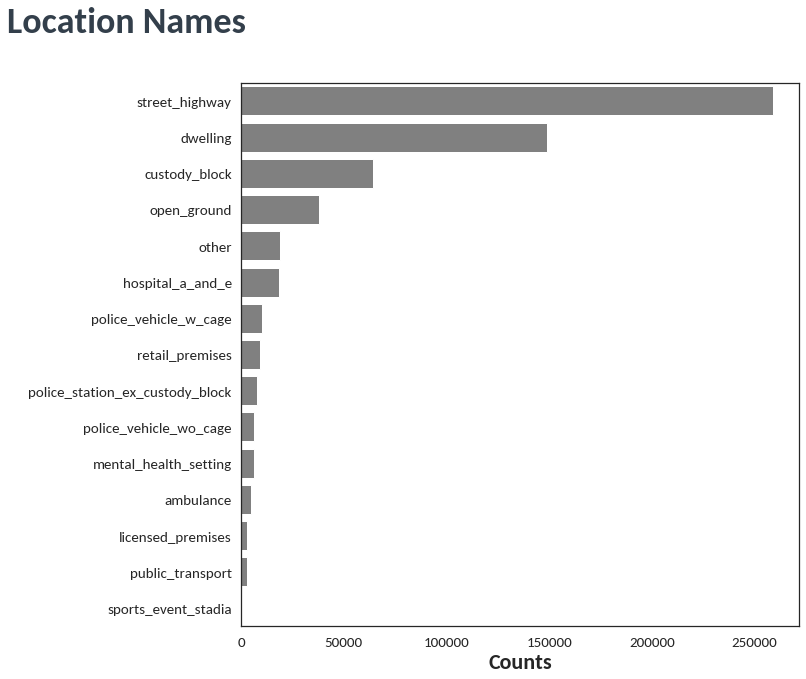

In [88]:
fig, _ = plt.subplots(1, figsize=(10,10))

ax = sns.barplot(x='counts', y='location_names', color='grey', data=location_counts_df.sort_values(by='counts', ascending=False))

fig.text(-0.2, 0.95, 'Location Names', fontsize=36, fontweight='black', color = '#333F4B')
ax.set_xlabel(xlabel="Counts", fontsize=22, fontweight='black')
ax.set_ylabel(ylabel='')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams['font.sans-serif'] = 'Carlito'

plt.savefig('fig1_locations.png', bbox_inches='tight')

This graph seems to suggest that the use of force by police in England and Wales tends to be in street highways, dwellings and custody blocks. We must take into account that use of force can take place in **multiple** locations (e.g. a person escaping from their dwelling into a street) and police officers aren't always able to report multiple locations (depending on individual police forces). The "other" value seems to be quite vague and as far as I know, it is unexplained.

In [14]:
impact_counts_df = get_col_counts_for_yes(police_df, 'impact', skipchars=14)
impact_counts_df

,impact_names,counts
0,possession_weapon,87489
1,alcohol,186810
2,drugs,179256
3,mental_health,130298
4,prior_knowledge,134861
5,size_gender_build,173676
6,acute_behavioural_disorder,12468
7,crowd,43195
8,other,96025


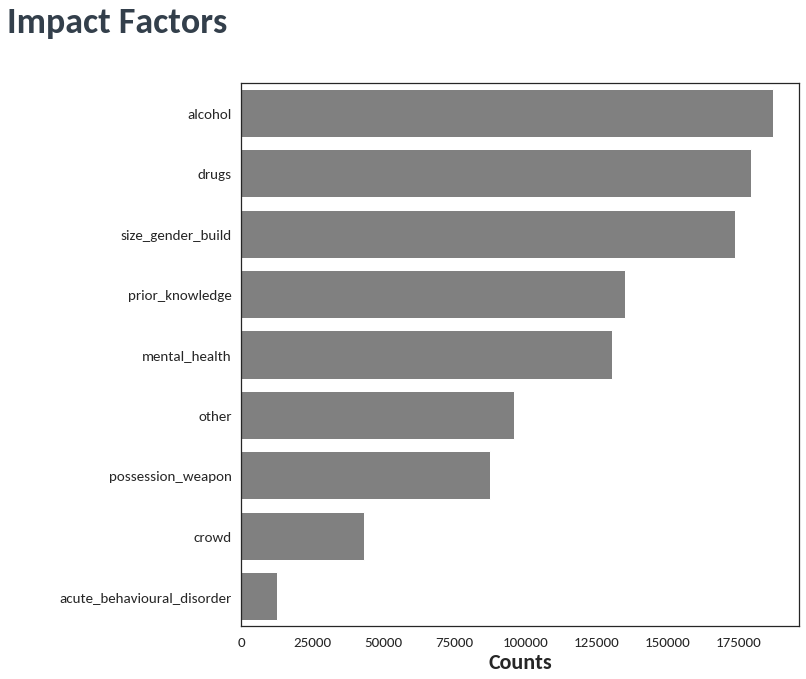

In [89]:
fig, _ = plt.subplots(1, figsize=(10,10))

ax = sns.barplot(x='counts', y='impact_names', color='grey', data=impact_counts_df.sort_values(by='counts', ascending=False))

fig.text(-0.2, 0.95, 'Impact Factors', fontsize=36, fontweight='black', color = '#333F4B')
ax.set_xlabel(xlabel="Counts", fontsize=22, fontweight='black')
ax.set_ylabel(ylabel='')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams['font.sans-serif'] = 'Carlito'

plt.savefig('fig2_impact_factors.png', bbox_inches='tight')

Impact factors are factors that are taken into consideration when police makes use of force (e.g. batons, stun guns, dogs). This graph suggests that alcohol, drugs and general body build seem to be the most important factors which makes sense as drug users can act irrationally and individuals with a strong body build can be dangerous. I am not entirely sure what is meant by "prior knowledge" but I could see it being linked to possession of a weapon or illegal drugs.

Interestingly enough, mental health seems to be a fairly significant impact factor where police may have to deal with mentally unstable individuals or maybe even individuals attempting suicide (this latter case isn't quite clear).

Some limitations to take into account:
- Not all police forces can report multiple impact factors
- Impact factors may be over-reported in some forces (mandatory field)

In [16]:
reason_counts_df = get_col_counts_for_yes(police_df, 'reason', skipchars=7)
reason_counts_df

,reason_names,counts
0,protect_self,391202
1,protect_public,163461
2,protect_person,246293
3,protect_other_officers,338732
4,prevent_offence,190335
5,secure_evidence,104938
6,effect_stop_search,17361
7,effect_search_custody,6088
8,effect_other_search,133415
9,effect_arrest,286695


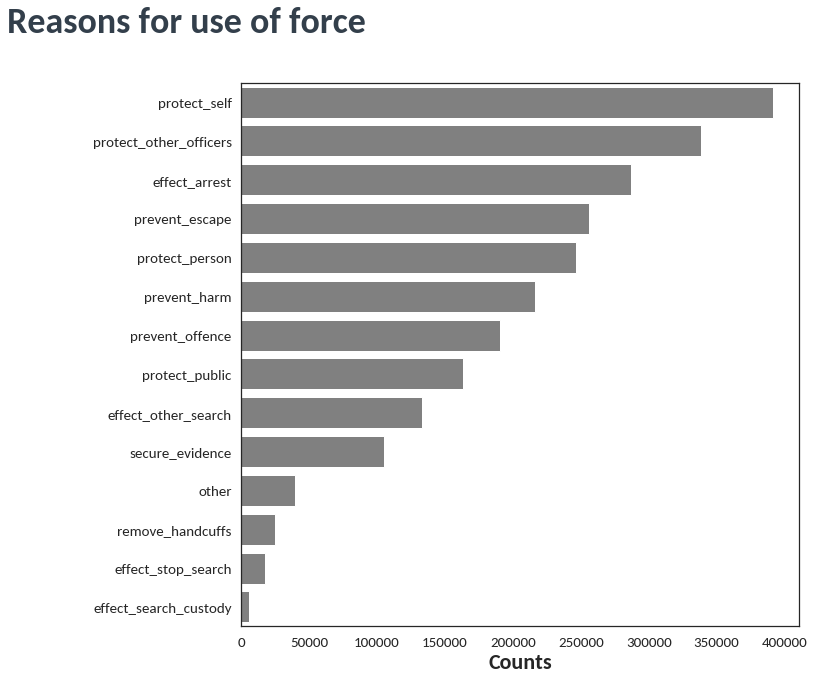

In [90]:
fig, _ = plt.subplots(1, figsize=(10,10))

ax = sns.barplot(x='counts', y='reason_names', color='grey', data=reason_counts_df.sort_values(by='counts', ascending=False))

fig.text(-0.2, 0.95, 'Reasons for use of force', fontsize=36, fontweight='black', color = '#333F4B')
ax.set_xlabel(xlabel="Counts", fontsize=22, fontweight='black')
ax.set_ylabel(ylabel='')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.rcParams['font.sans-serif'] = 'Carlito'

plt.savefig('fig3_reasons_for_force.png', bbox_inches='tight')

This graph suggests that police officers may have to use force to defend themselves but also to prevent escapes, harm and offences. For this type of data, I would expect there to be **multiple** reasons for use of force but police officers may not be able to select multiple reasons (this could bring the data much closer together). As a result, I think this graph shows the most common reasons amongst the multiple reasons and it brings a bunch of questions such as: 
1. Wouldn't "prevent_harm" and "protect_self" be essentially the same thing?
2. How would a reporting officer fill in the data when the meanings between the words are blurred?

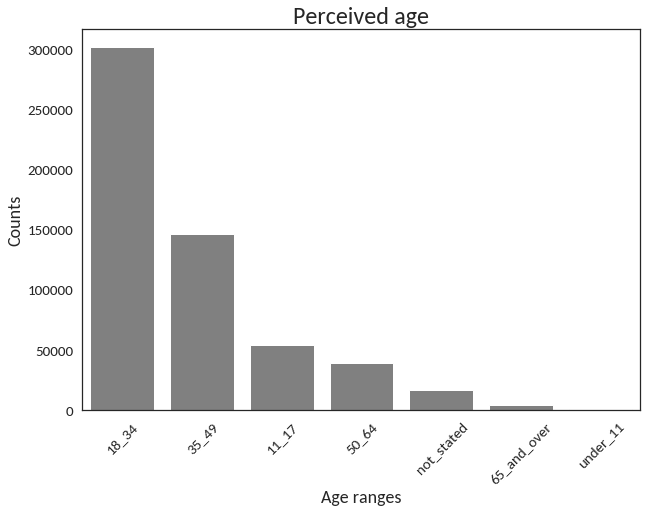

In [91]:
fig, _ = plt.subplots(1, figsize=(10,7))

perceived_age = police_df['person_perceived_age']
ax = sns.barplot(x=perceived_age.unique(), color='grey', y=perceived_age.value_counts())

plt.title('Perceived age', fontsize=24)
ax.set_ylabel(ylabel='Counts', fontsize=18)
ax.set_xlabel(xlabel='Age ranges', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='x', which='major', rotation=45)
plt.rcParams['font.sans-serif'] = 'Carlito'

plt.savefig('fig4_perceived_age.png', bbox_inches='tight')

Unsurprisingly, police officers seem to utilise use of force on younger people in the 18 to 34 age bracket. This would fit the stereotype of a young criminal but when you compare the 11 to 17 age bracket against the 50 to 64 age bracket, this stereotype may not seem as "true" as it appears on the surface.

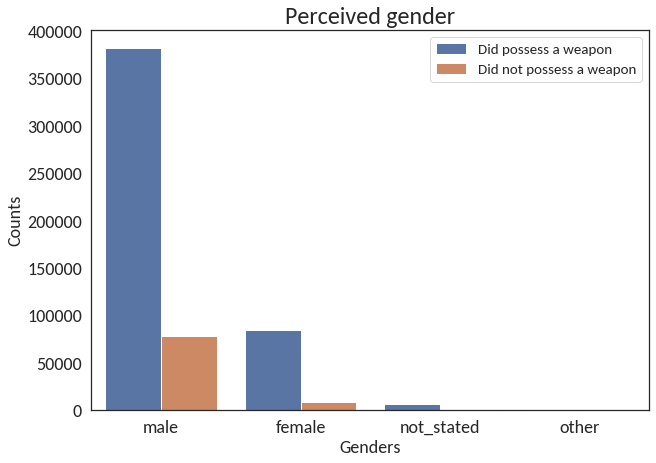

In [93]:
fig, _ = plt.subplots(1, figsize=(10,7))

possessed_weapon = police_df['impact_factor_possession_weapon'].map({'yes': True, 'no': False}).astype(bool)
ax = sns.countplot(x=police_df['person_perceived_gender'],  hue=possessed_weapon)

plt.title('Perceived gender', fontsize=24)
ax.set_ylabel(ylabel='Counts', fontsize=18)
ax.set_xlabel(xlabel='Genders', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.rcParams['font.sans-serif'] = 'Carlito'
ax.legend(['Did possess a weapon', 'Did not possess a weapon'], fontsize=15)

plt.savefig('fig5_perceived_genders.png', bbox_inches='tight')

While this data may not seem questionable on the surface, this does beg the question on why so many offenders are male. Even with the limitations on police recording gender, this does not explain the tremendous gap between male and female when the police makes use of force. To give a decent idea, according to a 2011 census, women and girls make up 51% of the England and Wales population where the ethnic groups have roughly the same proportions. You could argue that the use of force is necessary on men as men are stronger on average than women but women can easily make up for this through the use of weapons. However, when you look at whether or not women possed a weapon, it doesn't appear to matter, suggesting that this pattern is more sociological in nature.

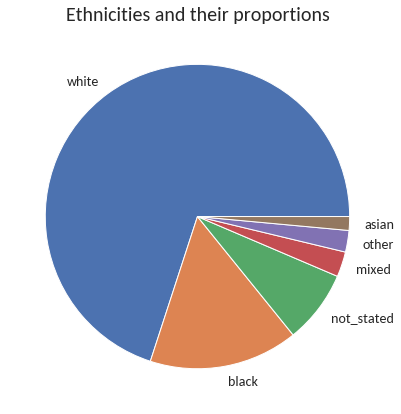

<Figure size 432x288 with 0 Axes>

In [20]:
_, _ = plt.subplots(1, figsize=(7,7))

ethnicities = police_df['person_perceived_ethnicity']
plt.pie(x=ethnicities.value_counts().values, labels=ethnicities.unique(), textprops={'fontsize': 14})
plt.title('Ethnicities and their proportions', fontsize=20)
plt.show()

plt.savefig('fig6_ethnicities.png', bbox_inches='tight')

This pie chart shows how the police use of force is inflicted on different ethnicities. From a glance this may appear unsurprising as England and Wales is composed of mostly White people but it appears that black people are also involved in a fairly significant way. This would make sense if this closely matches the proportion of ethnicities in England and Wales across the board. However, according to data on ethnicity in the 2011 census, ethnicities that may belong to "Black/African/Caribbean/Black British" cover 3.3% of the population whilst "Asian/Asian British" covers 7.5% of the population. 

While it could be argued that police officers can mix up certain ethnicities (e.g. mixed races can be more tricky to identify) and that this data is over a decade old, this does raise a question as to why a noticeable proportion of the police use of force is being inflicted on people with a "black" ethnicity, especially since skin colour can be an indicator of ethnicity to some degree. You could argue that there is an issue of racism within the police force towards people of a black ethnicity but I believe that there could be other explanations for this. For example, the idea of "systemic racism" suggests that racism is embedded within the "system" (e.g. education, medical care, immigration policy), meaning that the police use of force on people of black ethnicity could be a byproduct of a bigger problem. Another explanation could be that black people are more likely to live in poverty compared to white people and people in poverty are more likely to commit crimes due to lack of access to public services and other reasons. A more esoteric explanation could be "violent subculture theory" or "subculture of violence theory" which suggests that some black communities developed cultural values more "tolerant" to crime. An in-depth look at ethnicity and crime is beyond the scope of this EDA.

#### Sources
https://www.ons.gov.uk/peoplepopulationandcommunity/culturalidentity/ethnicity/articles/ethnicityandnationalidentityinenglandandwales/2012-12-11
https://webarchive.nationalarchives.gov.uk/ukgwa/20160105160709/http://www.ons.gov.uk/ons/resources/figure1_tcm77-290598.png

In [36]:
police_df['person_injury_level'].value_counts()

not_applicable    526727
minor              27495
not_stated          7474
severe               576
death                  8
Name: person_injury_level, dtype: int64

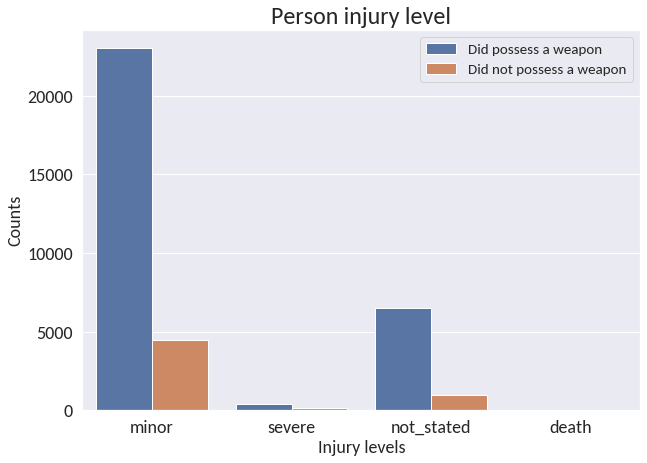

In [42]:
fig, _ = plt.subplots(1, figsize=(10,7))

possessed_weapon = police_df['impact_factor_possession_weapon'].map({'yes': True, 'no': False}).astype(bool)
filtered_injury_level = police_df[police_df['person_injury_level'] != 'not_applicable']['person_injury_level']
ax = sns.countplot(x=filtered_injury_level, hue=possessed_weapon)

plt.title('Person injury level', fontsize=24)
ax.set_ylabel(ylabel='Counts', fontsize=18)
ax.set_xlabel(xlabel='Injury levels', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.rcParams['font.sans-serif'] = 'Carlito'
ax.legend(['Did possess a weapon', 'Did not possess a weapon'], fontsize=15)

plt.savefig('fig7_injury_levels.png', bbox_inches='tight')

I find this data strange because of how many "not_stated" values there are. You would think that injury levels would be a mandatory field to fill in and that this data would be more nuanced.

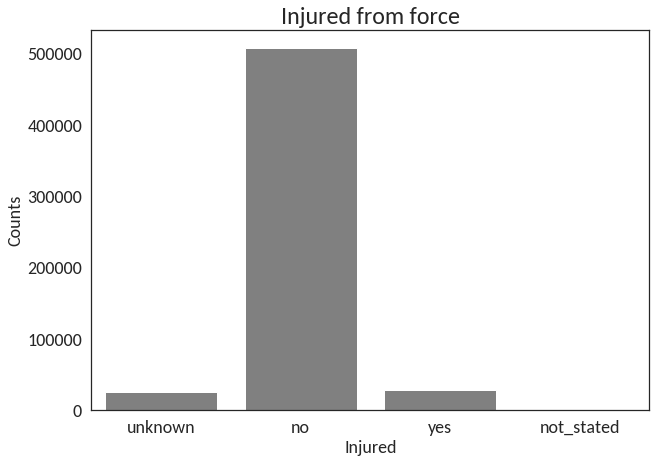

In [94]:
fig, _ = plt.subplots(1, figsize=(10,7))

ax = sns.countplot(x=police_df['person_injured_from_force'], color='grey',)

plt.title('Injured from force', fontsize=24)
ax.set_ylabel(ylabel='Counts', fontsize=18)
ax.set_xlabel(xlabel='Injured', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.rcParams['font.sans-serif'] = 'Carlito'

plt.savefig('fig8_injured_from_force.png', bbox_inches='tight')

Much like the previous section, this also confuses me because of how many "unknowns" there are, especially when compared to the amount of "yes" values there are. 

From reading the user guide, it turns out that injuries to individuals can be reported even when police officers didn't cause the injury which could explain the amount of unknown values and injury information is said to be contradictory according to the user guide.

In [76]:
force_counts = police_df['police_force'].value_counts()
forces_df = pd.DataFrame({'forces': force_counts.index, 'counts': force_counts.values})
forces_df = forces_df.sort_values(by='counts', ascending=False)
forces_df

,forces,counts
0,Metropolitan,172451
1,West Yorkshire,32866
2,South Wales,23116
3,Northumbria,19864
4,Essex,19358
5,Sussex,17497
6,Greater Manchester,16167
7,Cleveland,15092
8,Thames Valley,14833
9,West Midlands,14809


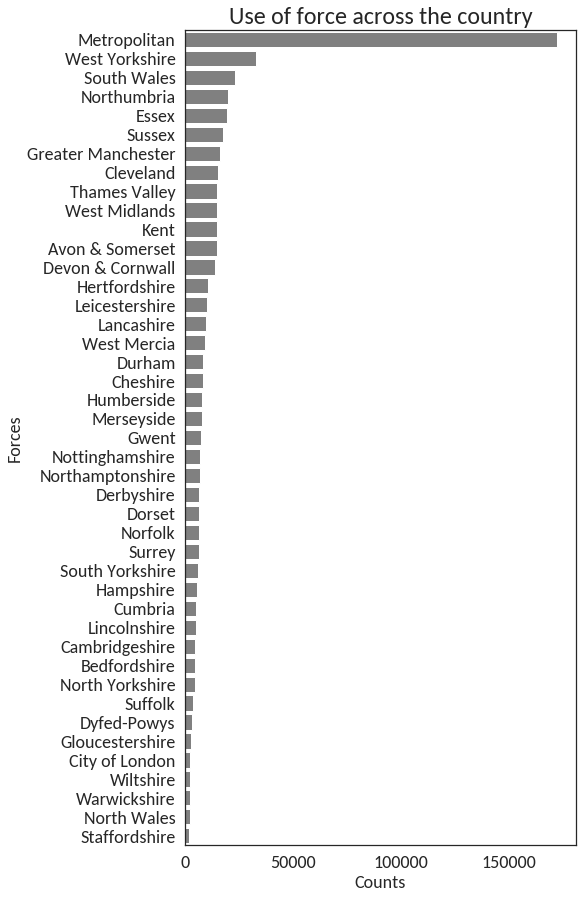

In [95]:
fig, _ = plt.subplots(1, figsize=(7,15))

police_force_counts = police_df['police_force'].value_counts()
ax = sns.barplot(x=forces_df['counts'], y=forces_df['forces'], color='grey',)

plt.title('Use of force across the country', fontsize=24)
ax.set_ylabel(ylabel='Forces', fontsize=18)
ax.set_xlabel(xlabel='Counts', fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.rcParams['font.sans-serif'] = 'Carlito'

plt.savefig('fig9_police_forces.png', bbox_inches='tight')